# Workspace \#10: Parameter Space

In [1]:
# getting future division
from __future__ import division

# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import ticker
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random, choice

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md
import green as gr

In [3]:
# Important quantities for aberration estimate
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]

## 1. Loading other axion limits

In [4]:
sys.path.insert(0, '../axion_limits/')
from PlotFuncs_mod import gen_constraints

(<Figure size 648x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2162980f50>)

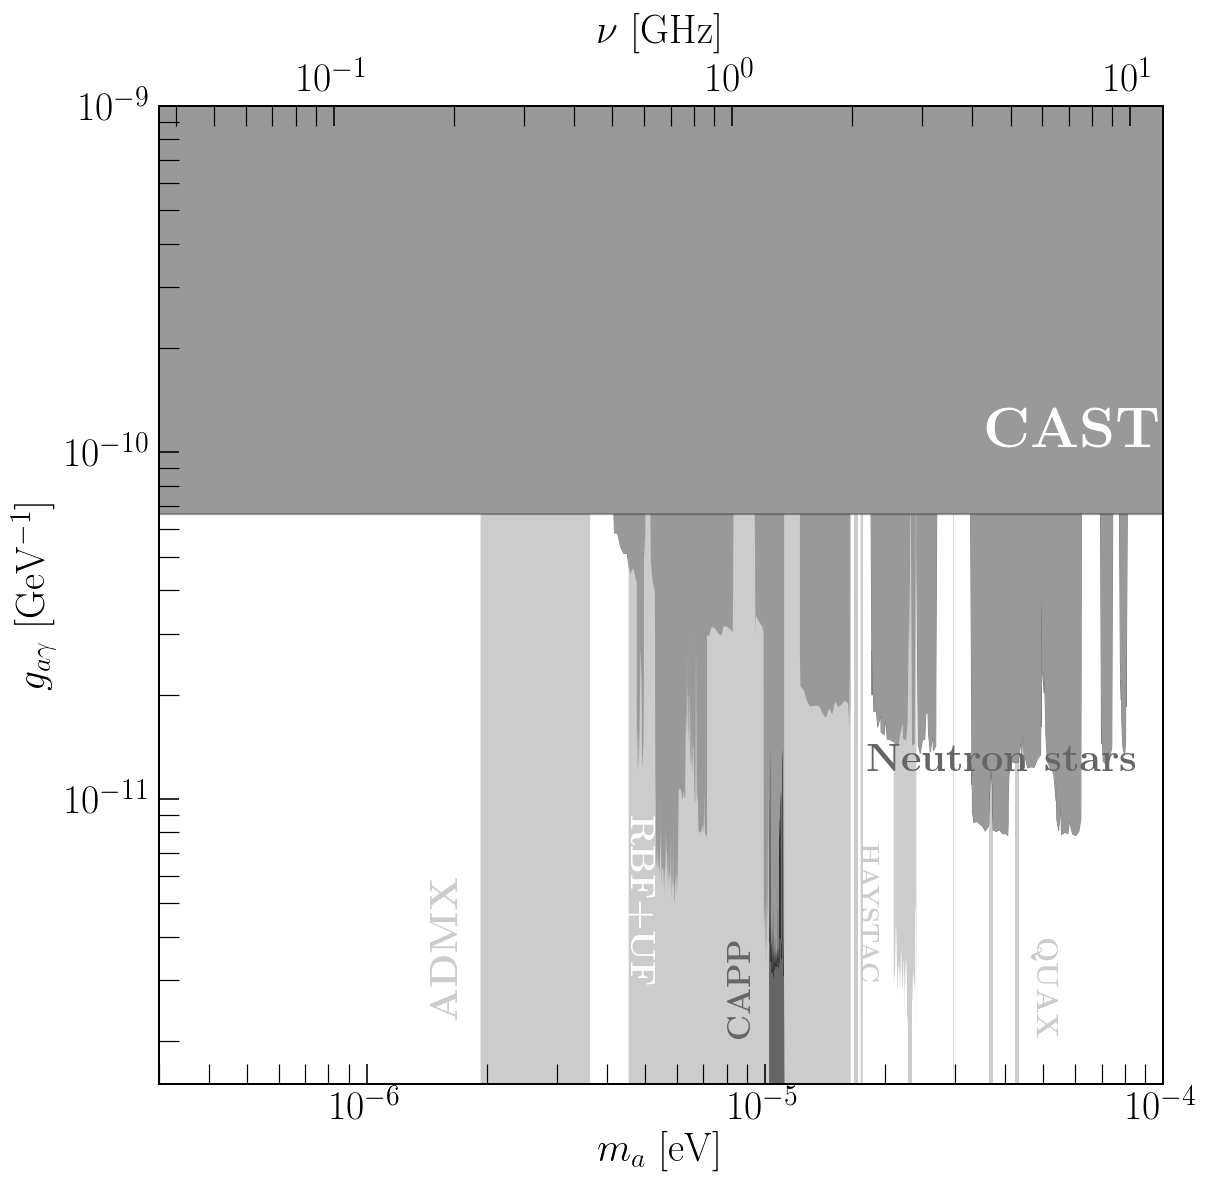

In [5]:
gen_constraints()

## 2. Loading Green's Catalog Results

In [6]:
CasA = 'G111.7-2.1'
W28 = 'G6.4-0.1'
W50 = 'G39.7-2.0'
Kepler = 'G4.5+6.8'
Crab = 'G184.6−5.8'
Vela = 'G263.9−3.3'
SgrAEast = 'G0.0+0.0'

In [7]:
help(gr.load_green_results)

Help on function load_green_results in module green:

load_green_results(name, run_id=None)
    Function that loads the numerical results for the SNRs from Green's Catalog.



### 2.1 $(m_a, g_{a\gamma\gamma})$

In [57]:
ma_ga_reach = {}
for run_id in tqdm(range(1,13)):
    
    ma_ga_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
        
        try:
            _, ma, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ma_ga_reach[run_id][name] = np.vstack((ma, res['ga'])).T


# repeating the process, but for some special runs
for run_id in tqdm([101, 102]):
    
    ma_ga_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
        
        try:
            _, ma, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ma_ga_reach[run_id][name] = np.vstack((ma, res['ga'])).T

del run_id, name, ma, res

100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


In [58]:
runs_mins = {}
for run_id in range(1, 13):
    reach = ma_ga_reach[run_id]
    try:
        tmp = {name:min(maga[:,1]) for name, maga in reach.items()}
        min_name = min(tmp, key=tmp.__getitem__)
        runs_mins[run_id] = min_name, min(reach[min_name][:,1])
    except:
        continue

del run_id, reach, tmp, min_name

In [59]:
runs_mins

{1: ('G39.7-2.0', 7.113004982612774e-11),
 2: ('G39.7-2.0', 1.1695437991924591e-10),
 3: ('G327.6+14.6', 4.594067739633432e-09),
 4: ('G65.3+5.7', 4.8617978756541616e-11),
 5: ('G65.3+5.7', 2.7948152813198205e-10),
 6: ('G39.7-2.0', 4.374509443176288e-11),
 7: ('G39.7-2.0', 3.129621211632046e-11),
 8: ('G39.7-2.0', 5.1458266806119434e-11),
 9: ('G327.6+14.6', 1.5863822507574213e-09),
 10: ('G119.5+10.2', 3.1097881441551447e-11),
 11: ('G119.5+10.2', 1.8151761414867836e-10),
 12: ('G39.7-2.0', 1.9247220516947166e-11)}

### 2.2 $(L_{\rm pk}, t_{\rm pk})$

### 2.3 $(t_{\rm trans}, t_{\rm pk})$

In [60]:
ttr_tpk_reach = {}
for run_id in tqdm(range(19,25)):
    
    ttr_tpk_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
        
        try:
            _, pars, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ttr, tpk = pars
        
        ttr_tpk_reach[run_id][name] = (ttr, tpk, res['ga'], res['Lpk'])

del run_id, name, pars, res, ttr, tpk

100%|██████████| 6/6 [00:16<00:00,  2.79s/it]


## 3. Plots

In [ ]:
def float_exp(num):
    
    dex = int(np.floor(log10(num)))
    lead = 10.**(log10(num)-dex)
    
    if lead == 1.:
        return r"$10^{%d}$" % dex
    else:
        return r"$%.0f \times 10^{%d}$" % (lead, dex)
    
    return lead, dex

In [61]:
gr.load_green_results(W50, run_id=4)[-1]

{'echo': array([2.03809235e-04, 1.90504014e-04, 1.78067394e-04, 1.66442670e-04,
        1.55576840e-04, 1.45420361e-04, 1.35926925e-04, 1.27053245e-04,
        1.18758864e-04, 1.11005963e-04, 1.03759192e-04, 9.69855094e-05,
        9.06540317e-05, 8.47358900e-05, 7.92041007e-05, 7.40334417e-05,
        6.92003374e-05, 6.46827512e-05, 6.04600853e-05, 5.65130866e-05,
        5.28237586e-05, 4.93752801e-05, 4.61519275e-05, 4.31390042e-05,
        4.03227728e-05, 3.76903925e-05, 3.52298612e-05, 3.29299601e-05,
        3.07802028e-05, 2.87707875e-05, 2.68925522e-05, 2.51369333e-05,
        2.34959260e-05, 2.19620480e-05, 2.05283058e-05, 1.91881622e-05,
        1.79355068e-05, 1.67646282e-05, 1.56701877e-05, 1.46471952e-05,
        1.36909865e-05, 1.27972017e-05, 1.19617655e-05, 1.11808690e-05,
        1.04509514e-05, 9.76868492e-06, 9.13095861e-06, 8.53486481e-06,
        7.97768563e-06, 6.99615097e-06, 6.13537944e-06, 5.38051294e-06,
        4.71852146e-06, 4.13797811e-06, 3.62886191e-06, 

### 3.1 $(m_a, g_{a\gamma\gamma})$

In [62]:
def ma_ga_arr(snr_name, sd_run, if_run):
    
    lines, ma, sd_res = gr.load_green_results(snr_name, run_id=sd_run)
    _, _, if_res = gr.load_green_results(snr_name, run_id=if_run)
    
    try:
        Lpk_idx = [('L_peak:' in line) for line in lines].index(True)
        Lpk = float(lines[Lpk_idx].split()[-1])
        
        tpk_idx = [('t_peak:' in line) for line in lines].index(True)
        tpk = float(lines[tpk_idx].split()[-1])
        
        extra = Lpk, tpk
        
    except:
        
        ttr_idx = [('t_trans:' in line) for line in lines].index(True)
        ttr = float(lines[ttr_idx].split()[-1])
    
        extra = ttr
    
    ma_ga = np.vstack((ma, np.minimum.reduce((sd_res['ga'], if_res['ga'])))).T
    
    return ma_ga, extra

In [63]:
ma_ga_arr(W50, 2, 8)

(array([[4.30321005e-07, 7.56150174e-11],
        [4.47753969e-07, 7.01578556e-11],
        [4.65893170e-07, 6.61875379e-11],
        [4.84767217e-07, 6.31737965e-11],
        [5.04405880e-07, 6.06939885e-11],
        [5.24840137e-07, 5.86172180e-11],
        [5.46102216e-07, 5.70190267e-11],
        [5.68225654e-07, 5.57745559e-11],
        [5.91245347e-07, 5.48639286e-11],
        [6.15197603e-07, 5.41965741e-11],
        [6.40120202e-07, 5.37323008e-11],
        [6.66052454e-07, 5.33703731e-11],
        [6.93035260e-07, 5.24623448e-11],
        [7.21111182e-07, 5.17509269e-11],
        [7.50324502e-07, 5.14582668e-11],
        [7.80721299e-07, 5.23648044e-11],
        [8.12349517e-07, 5.33324691e-11],
        [8.45259042e-07, 5.47660686e-11],
        [8.79501782e-07, 5.66419913e-11],
        [9.15131749e-07, 5.86129716e-11],
        [9.52205140e-07, 6.04501485e-11],
        [9.90780431e-07, 6.24185220e-11],
        [1.03091847e-06, 6.45137113e-11],
        [1.07268255e-06, 6.6782803

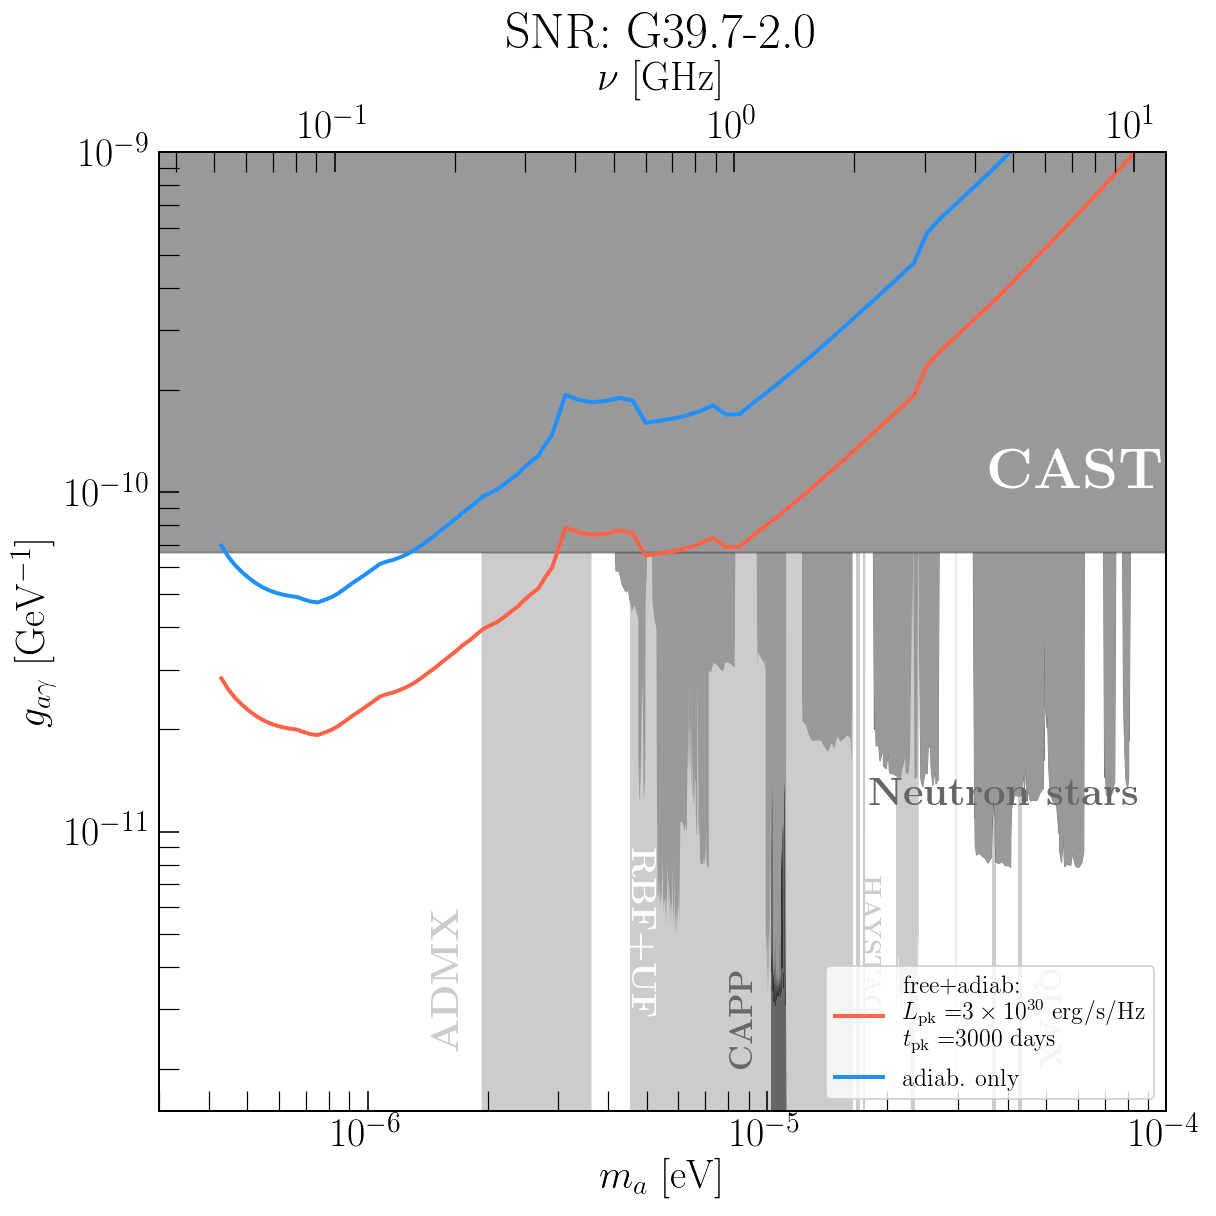

In [162]:
# whether we want to zoom the plot
zoomed = False

name = W50
# name = 'G119.5+10.2'
# name = 'G114.3+0.3'
# name = 'G65.3+5.7'

# runs for adiabatic only, t_trans = 300
# ad_sd_run, ad_if_run = 2, 8

# runs for adiabatic only, t_trans = 249
ad_sd_run, ad_if_run = 101, 102

# reach for adiabatic only:
ad_reach, ttr = ma_ga_arr(name, ad_sd_run, ad_if_run)

# runs for free+adiabatic, t_trans = 249
fa_sd_run, fa_if_run = 6, 12
# fa_sd_run, fa_if_run = 4, 10
fa_reach, pars = ma_ga_arr(name, fa_sd_run, fa_if_run)
Lpk, tpk = pars

fix, ax = gen_constraints()

ax.loglog(fa_reach[:,0], fa_reach[:,1], lw=2., color="tomato", label="free+adiab:\n"+r"$L_{\rm pk} = $"+float_exp(Lpk)+r" $\mathrm{erg/s/Hz}$"+"\n"+r"$t_{\rm pk} = $"+"{} days".format(int(tpk)))
# ax.fill_between(fa_reach[:,0], fa_reach[:,1], ad_reach[:,1], alpha=0.3, color="tomato", zorder=50, label="free+adiab\n"+r"$L_{\rm pk} = $"+float_exp(Lpk)+r" $\mathrm{erg/s/Hz}$"+"\n"+r"$t_{\rm pk} = $"+"{}".format(int(tpk)))

ax.loglog(ad_reach[:,0], ad_reach[:,1], lw=2., color="dodgerblue", label="adiab. only")
# ax.fill_between(ad_reach[:,0], ad_reach[:,1], 1.e-9, alpha=0.3, color="dodgerblue", zorder=50, label="adiab. only")

if zoomed:
    ax.set_xlim(3.e-7, 1.e-4)
    ax.set_ylim(1.e-12, 1.e-9)

ax.legend(fontsize=12, loc="lower right");
ax.set_title("SNR: %s" % name, fontsize=25);

plt.tight_layout()

file_name = "ma_ga_reach_%s.pdf" % name.replace(".", "")
plt.savefig("plots/"+file_name, bbox_inches="tight")

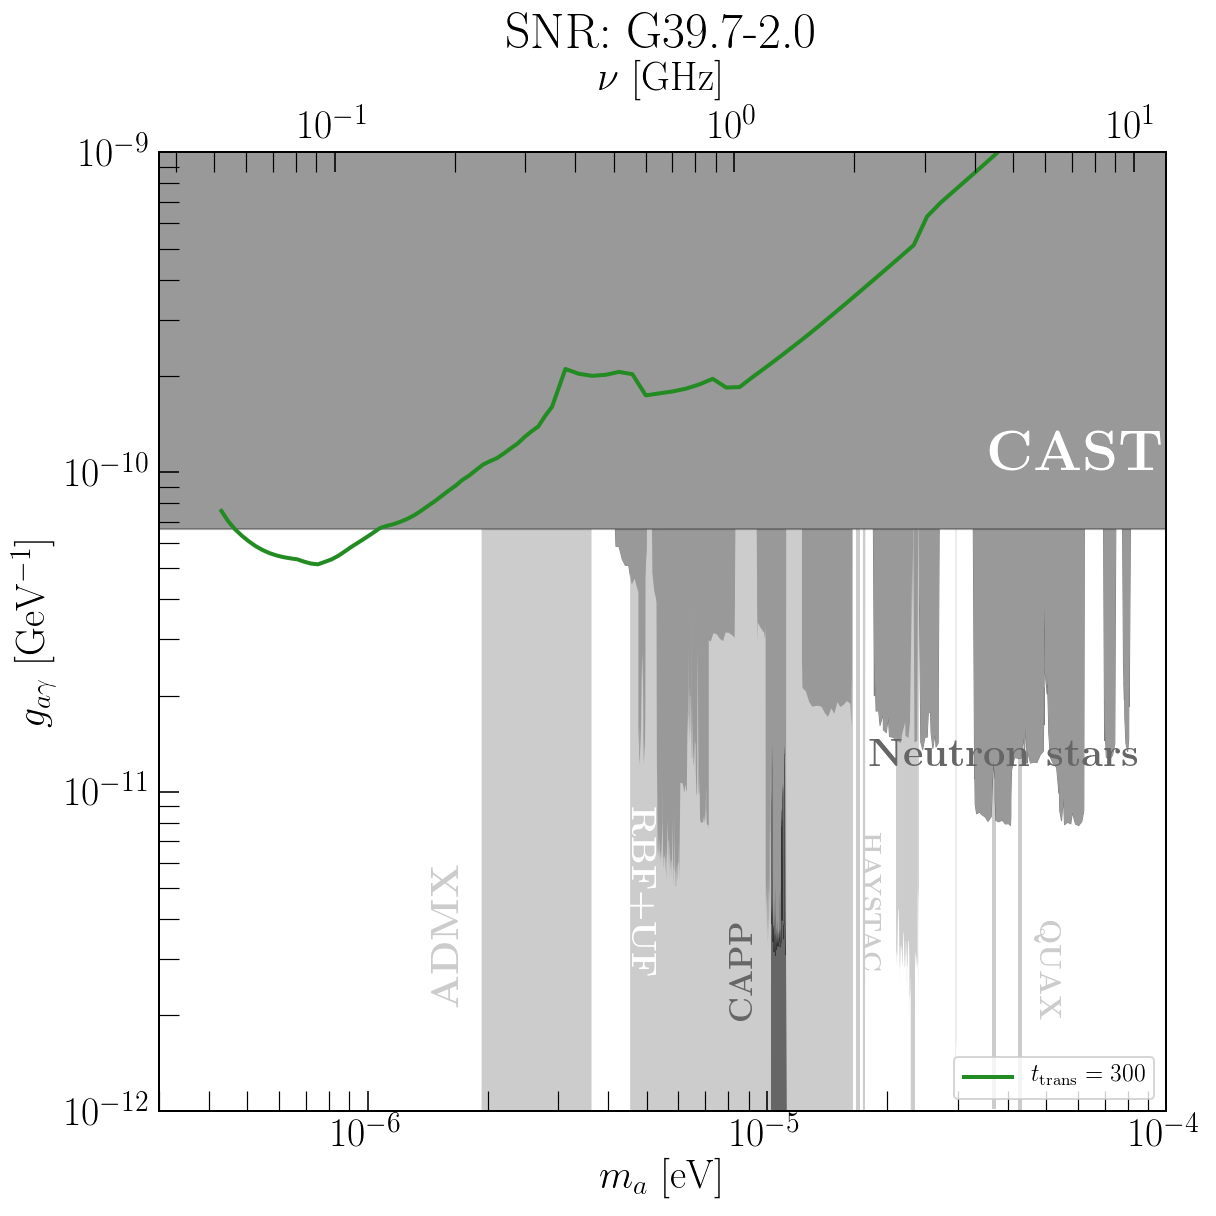

In [68]:
# whether we want to zoom the plot
zoomed = True

name = W50

# runs for adiabatic only, t_trans = 300
ad_sd_run, ad_if_run = 2, 8

# reach for adiabatic only:
ad_reach, ttr = ma_ga_arr(name, ad_sd_run, ad_if_run)

fix, ax = gen_constraints()

ax.loglog(ad_reach[:,0], ad_reach[:,1], lw=2., color="forestgreen", label=r"$t_{\rm trans} = %.0f$" % ttr)

if zoomed:
    ax.set_xlim(3.e-7, 1.e-4)
    ax.set_ylim(1.e-12, 1.e-9)

ax.legend(fontsize=12, loc="lower right");
ax.set_title("SNR: %s" % name, fontsize=25);

plt.tight_layout()

file_name = "compare_reach_%s.pdf" % name.replace(".", "")
plt.savefig("plots/"+file_name, bbox_inches="tight")

### 3.2 $(L_{\rm pk}, t_{\rm pk})$

### 2.3 $(t_{\rm trans}, t_{\rm pk})$

In [69]:
def ttr_tpk_results(snr_name, sd_run, if_run):
    
    lines, pars, sd_res = gr.load_green_results(snr_name, run_id=sd_run)
    _, _, if_res = gr.load_green_results(snr_name, run_id=if_run)
    
    ttr, tpk = pars
    # merging single-dish and interferometry
    ga_reach = np.minimum.reduce((sd_res['ga'], if_res['ga']))
    
    # Lpk conversion factor (pivot --> Bietenholz)
    alpha = dt.snrs_dct[snr_name].get_spectral_index()
    from_pivot_to_Bietenholz = (8./1.)**-alpha
    Lpk_Biet = sd_res['Lpk']*from_pivot_to_Bietenholz
    
    sigmas = (log10(Lpk_Biet) - ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_
    
    return ttr, tpk, ga_reach, sd_res['Lpk'], sigmas

In [70]:
ttr_tpk_results(W50, 19, 22)

(array([ 100.,  109.,  118.,  127.,  136.,  145.,  154.,  163.,  172.,
         181.,  190.,  199.,  208.,  217.,  226.,  235.,  244.,  253.,
         262.,  271.,  280.,  289.,  298.,  307.,  316.,  325.,  334.,
         343.,  352.,  361.,  370.,  379.,  388.,  397.,  406.,  415.,
         424.,  433.,  442.,  451.,  460.,  469.,  478.,  487.,  496.,
         505.,  514.,  523.,  532.,  541.,  550.,  559.,  568.,  577.,
         586.,  595.,  604.,  613.,  622.,  631.,  640.,  649.,  658.,
         667.,  676.,  685.,  694.,  703.,  712.,  721.,  730.,  739.,
         748.,  757.,  766.,  775.,  784.,  793.,  802.,  811.,  820.,
         829.,  838.,  847.,  856.,  865.,  874.,  883.,  892.,  901.,
         910.,  919.,  928.,  937.,  946.,  955.,  964.,  973.,  982.,
         991., 1000.]),
 array([1.00000000e-01, 1.13100714e-01, 1.27917715e-01, 1.44675849e-01,
        1.63629418e-01, 1.85066040e-01, 2.09311013e-01, 2.36732250e-01,
        2.67745865e-01, 3.02822485e-01, 3.42494392e

In [71]:
ttr_tpk_results(W50, 19, 22)[2].min()

4.081039297439219e-12

In [72]:
ttr_tpk_results(W50, 20, 23)[2].min()

1.2729688547148824e-12

In [73]:
ttr_tpk_results(W50, 21, 24)[2].min()

3.165861873772537e-11

In [116]:
pt.nu_from_ma(1.e-6)

array(0.12089946)

In [136]:
import matplotlib.patches as mpatches

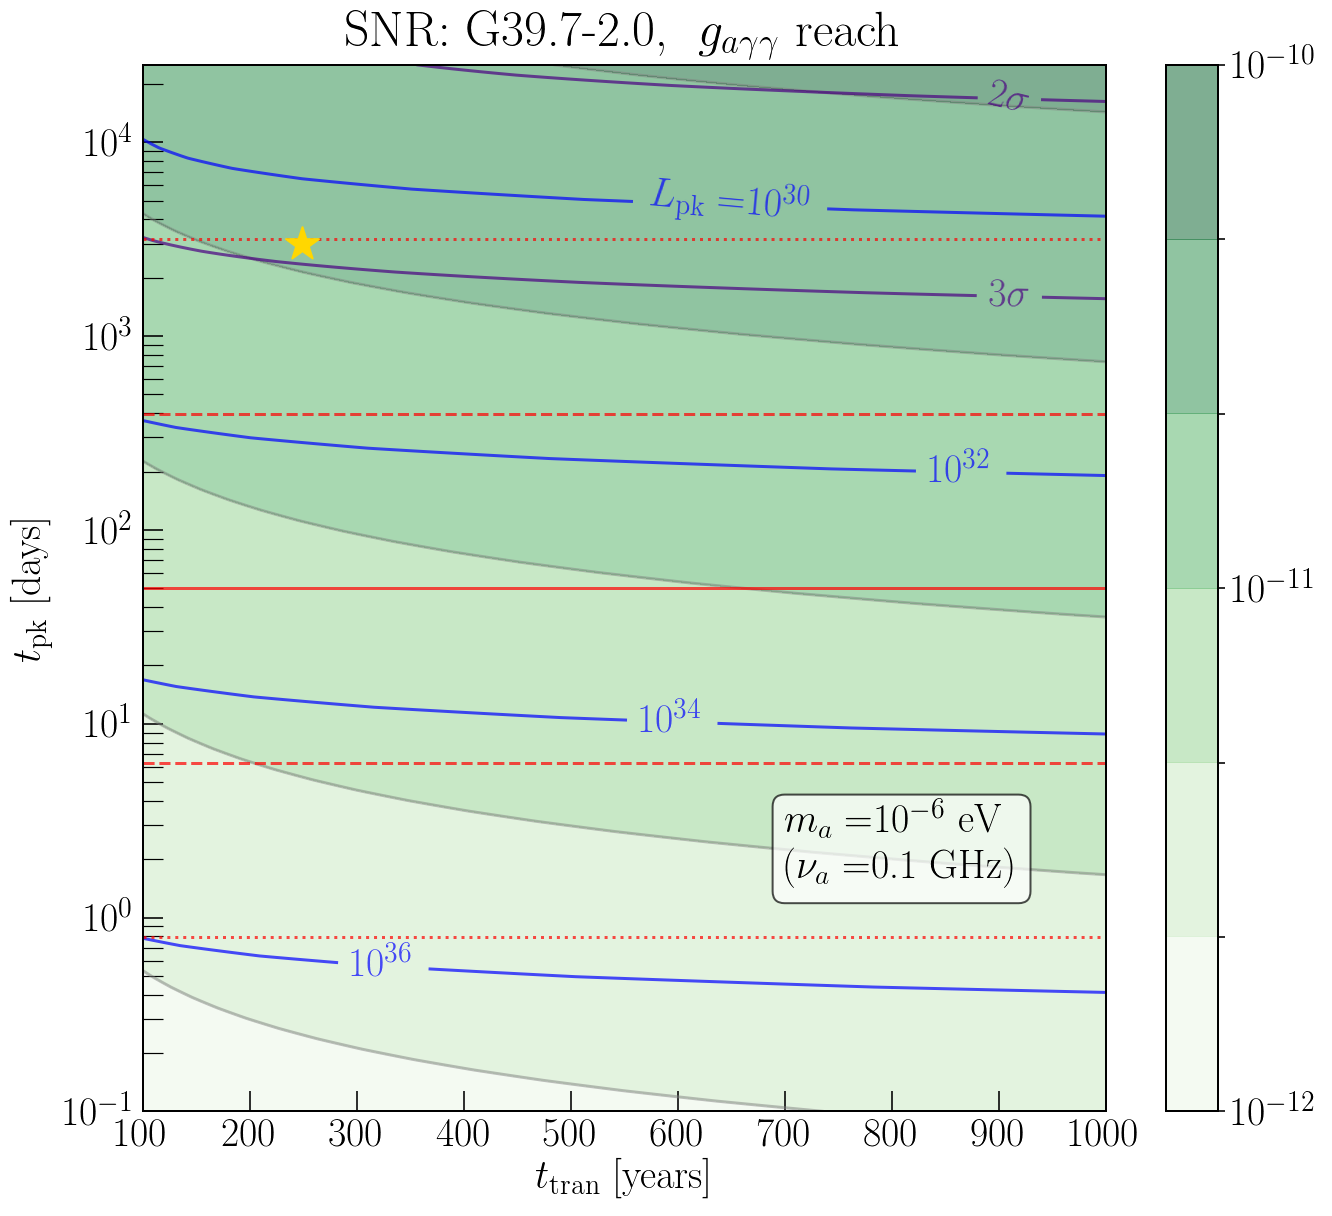

In [188]:
name = W50

sd_id = 20 # 19, 20, 21
if_id = sd_id+3

ttr, tpk, ga_reach, Lpk, sigs = ttr_tpk_results(name, sd_id, if_id)

lines, _, _ = gr.load_green_results(name, run_id=sd_id)
ma_idx = ['ma:' in line for line in lines].index(True)
ma = float(lines[ma_idx].split()[-1])

del lines, ma_idx

# Setting up plot

plt.rcParams['axes.linewidth'] = 1.
plt.rc('font', family='serif', size=25)
fig, ax = plt.subplots(figsize=(10, 9))

fs = 20  # fontsize
label_size = 20 # fontsize of labels

ga_min, ga_max = np.ceil(log10(ga_reach.min()))-1, np.floor(log10(ga_reach.max()))+1
decades = int(3*(ga_max - ga_min)+1)

ga_levels = 10.**(np.linspace(ga_min, ga_max, decades))
cs = ax.contourf(ttr, tpk, ga_reach, levels=ga_levels, locator=ticker.LogLocator(), alpha=0.5, cmap=plt.cm.Greens)
cbar = fig.colorbar(cs)
cbar.ax.tick_params(labelsize=20)
ax.contour(ttr, tpk, ga_reach, levels=ga_levels, locator=ticker.LogLocator(), alpha=0.5, colors=['grey'])

cs2 = ax.contour(ttr, tpk, Lpk, colors=['blue'], locator=ticker.LogLocator(), alpha=0.7)
# inline labeling
fmt = {}

strs = []
for i, lvl in enumerate(cs2.levels):
    if lvl == 1.e30:
        strs.append(r"$L_{\rm pk} = $"+float_exp(lvl))
    else:
        strs.append(float_exp(lvl))

for l, s in zip(cs2.levels, strs):
    fmt[l] = s
plt.clabel(cs2, cs2.levels, inline=True, fmt=fmt, fontsize=20)



cs3 = ax.contour(ttr, tpk, sigs, colors=['indigo'], levels=range(4), alpha=0.7)
# inline labeling
fmt = {}
strs = ['mean', r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(cs3.levels, strs):
    fmt[l] = s
plt.clabel(cs3, cs3.levels, inline=True, fmt=fmt, fontsize=20)



for ns in range(-2,3):
    val = 10.**(ct._mu_log10_tpk_ + ns*ct._sig_log10_tpk_)
    if ns in [-2, 2]:
        ls = ":"
    elif ns in [-1, 1]:
        ls = "--"
    else:
        ls = "-"
    ax.axhline(val, ls=ls, color='r', alpha=0.7)

del val

ax.scatter(249.07, 3000., s=300., zorder=25, marker='*', color="gold")

plt.yscale('log');
plt.xscale('linear');
plt.xlabel(r'$t_{\rm tran}$ [years]', fontsize=label_size)
plt.ylabel(r'$t_{\rm pk}$ [days]', fontsize=label_size);

props = dict(boxstyle='round', facecolor='white', alpha=0.7)

ax.text(700, 1.5, r"$m_a = $%s eV" % float_exp(ma)+"\n"+r"($\nu_a = $%.1f GHz)" % pt.nu_from_ma(ma), fontsize=20, bbox=props)
# ax.legend(fontsize=12, loc="lower right", handles="kkk");
ax.set_title("SNR: %s" % name + r", $\ g_{a\gamma\gamma}$ reach", fontsize=25);

ax.set_xticks(np.arange(100, 1100, 100))
ax.tick_params("both", which="both", labelsize=fs, direction="in", length=10.)

plt.tight_layout()

file_name = "ttr-tpk_reach_%s.pdf" % name.replace(".", "")
plt.savefig("plots/"+file_name, bbox_inches="tight")

del ma